In [80]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In this notebook I will be building a Logistic Regression model from scratch using python and then compare it against the standard implementation found in Sci-kit learn library

### Data Generation
First lets generate some sample data set to work with.

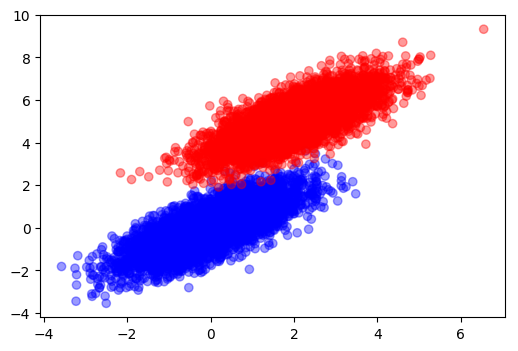

In [81]:
numSamples = 5000
negativeSamples = np.random.multivariate_normal([0, 0], [[1, .75],[.75, 1]], numSamples)
positiveSamples = np.random.multivariate_normal([2, 5], [[1, .75],[.75, 1]], numSamples)
samples = np.concatenate((negativeSamples, positiveSamples))
labels = np.concatenate((np.zeros(numSamples), np.ones(numSamples)))
plt.scatter(samples[:, 0], samples[:, 1], c = map(lambda x: 'b' if x == 0 else 'r', labels), alpha = 0.4)

The Data was intentionally generated such that it there was some amount of linear separation such that logistic regression could work

### Logistic Regression
Logistic Function
\begin{align}
f(x) & = \frac{1}{1 + e^{-w^Tx}}
\end{align}
Above I am have added the intercept term to the sample values itself by adding an extra dimension just to make the calculations simple.
Given that there are only two classes we can use the Bernoulli distribution to model the probability distribution
\begin{align}
P(y | x) = f(x)^y(1-f(x))^{1-y}
\end{align}
Given this our objective function for logistic regression turns out to:
\begin{align}
l(w) = \sum_{l=1}^N P(y_l | x_l, w)
\end{align}
The aim of logistic regression is to maximize the above value. Even though we can solve for this equation as well but taking log and then solving will make our calculation much simpler. So applying log on both sides
\begin{align}
ln(l(w)) = \sum_{l=1}^N ln(P(y_l | x_l, w)) \\
 = \sum_{l=1}^N yln(\frac{1}{1 + e^{-w^Tx}}) + (1-y)ln(1 - \frac{1}{1 + e^{-w^Tx}}) \\
 = \sum_{l=1}^N yln(\frac{1}{1 + e^{-w^Tx}}) + (1-y)ln(\frac{e^{-w^Tx}}{1 + e^{-w^Tx}}) \\
 = \sum_{l=1}^N ln(\frac{e^{-w^Tx}}{1+ e^{-w^Tx}}) - yln(e^{-w^Tx}) \\
 = \sum_{l=1}^N (y - 1)w^Tx - ln(1+ e^{-w^Tx}) \\
\end{align}

Now that we have simplified the problem a bit, we would like to solve for w but unfortunately there is no closed form solution for logistic regression which can lead us directly to the optimal w. Instead we have to use something like gradient ascent(it is just the opposite of gradient descent, we use it here as we have to maximize the value).
Taking partial derivate with respect to one of the dimension of vector w we get
\begin{align}
\frac{\partial l(w)}{\partial w_i} = \sum_{l=1}^N x_i^l(y^l - P(y^l | x^i, w))
\end{align}

P.S. l(w) above is same as ln(l(w)) I just changed the notation a bit to make the equation look a bit simpler

The update equation would look like
\begin{align}
w_{i+1} = w_i + n\sum_{l=1}^N x_i^l(y^l - P(y^l | x^l, w))
\end{align}

Here n represents the learning rate

Now that we have the equations worked out lets build it out

In [103]:
def sigmoid(x):
    return 1.0/(1 + np.exp(-x))

def update_w(x, y, w, learningRate):
    #This function performs one round of weight update using all the samples
    scores = np.dot(x, w) #calculation wTx
    predictionVals = sigmoid(scores) #getting the probabilities
    predictionError = y - predictionVals # yl−P(yl|xl,w)
    gradient = np.dot(x.T, predictionError) #This operation calculates the gradient for all dimension at once
    updateVal = learningRate * gradient
    return w + updateVal

def logistic_regression(x, y, learningRate, iterations=30000, add_intercept=True):
    if add_intercept:
        intercept = np.ones((x.shape[0], 1))
        x = np.hstack((x, intercept))
    # initializing w to be all zeroes
    w = np.zeros(x.shape[1])
    for it in xrange(iterations):
        w_new = update_w(x, y, w, learningRate)
        w = w_new
    return w

In [99]:
weights = logistic_regression(samples, labels, 1e-4, 30000, True)

In [109]:
# Lets check the training accuracy of the model trained
from sklearn.metrics import accuracy_score
y_pred = map(lambda x: 1 if x >= 0.5 else 0, sigmoid(np.dot(samples, weights[:2]) + weights[2] ))
print 'Training Accuracy:', accuracy_score(labels, y_pred)

Training Accuracy: 0.9985


In [108]:
#Though trained models should not judged based on their training accuracy but this atleast tells us that the model learned something
#Comparing against sklearn's implementation
from sklearn.linear_model import LogisticRegression
# putting C to a very high value to discard regularization as I haven't added a term for regularization
mdl = LogisticRegression(C=1e15, max_iter =30000)
mdl.fit(samples, labels)
print mdl.coef_, mdl.intercept_
print weights

[[-3.7105873  7.9527151]] [-16.16972923]
[ -3.39479514   7.28384609 -14.78495992]


The weights obtained are very close which should be the case if the implemented algorithm is correct. Though the weights are close, sklearn's implementation is way faster.